Конфигурационные файлы созданы:
- fuzzy_config.json
- room_config.json
- simulation_config.json
=== СИМУЛЯЦИЯ УМНОГО ОСВЕЩЕНИЯ ===

Конфигурация загружена из JSON файлов

--- 0.0 часов ---
Гостиная: вероятность присутствия людей = 25%, естественный свет = 43лк, мощность искуственного освещения = 36%
Спальня: вероятность присутствия людей = 95%, естественный свет = 90лк, мощность искуственного освещения = 56%
Кухня: вероятность присутствия людей = 1%, естественный свет = 38лк, мощность искуственного освещения = 18%
--- 2.0 часов ---
Гостиная: вероятность присутствия людей = 18%, естественный свет = 59лк, мощность искуственного освещения = 30%
Спальня: вероятность присутствия людей = 91%, естественный свет = 55лк, мощность искуственного освещения = 56%
Кухня: вероятность присутствия людей = 6%, естественный свет = 40лк, мощность искуственного освещения = 18%
--- 4.0 часов ---
Гостиная: вероятность присутствия людей = 25%, естественный свет = 55лк, мощность искуственного освещения = 37%
С

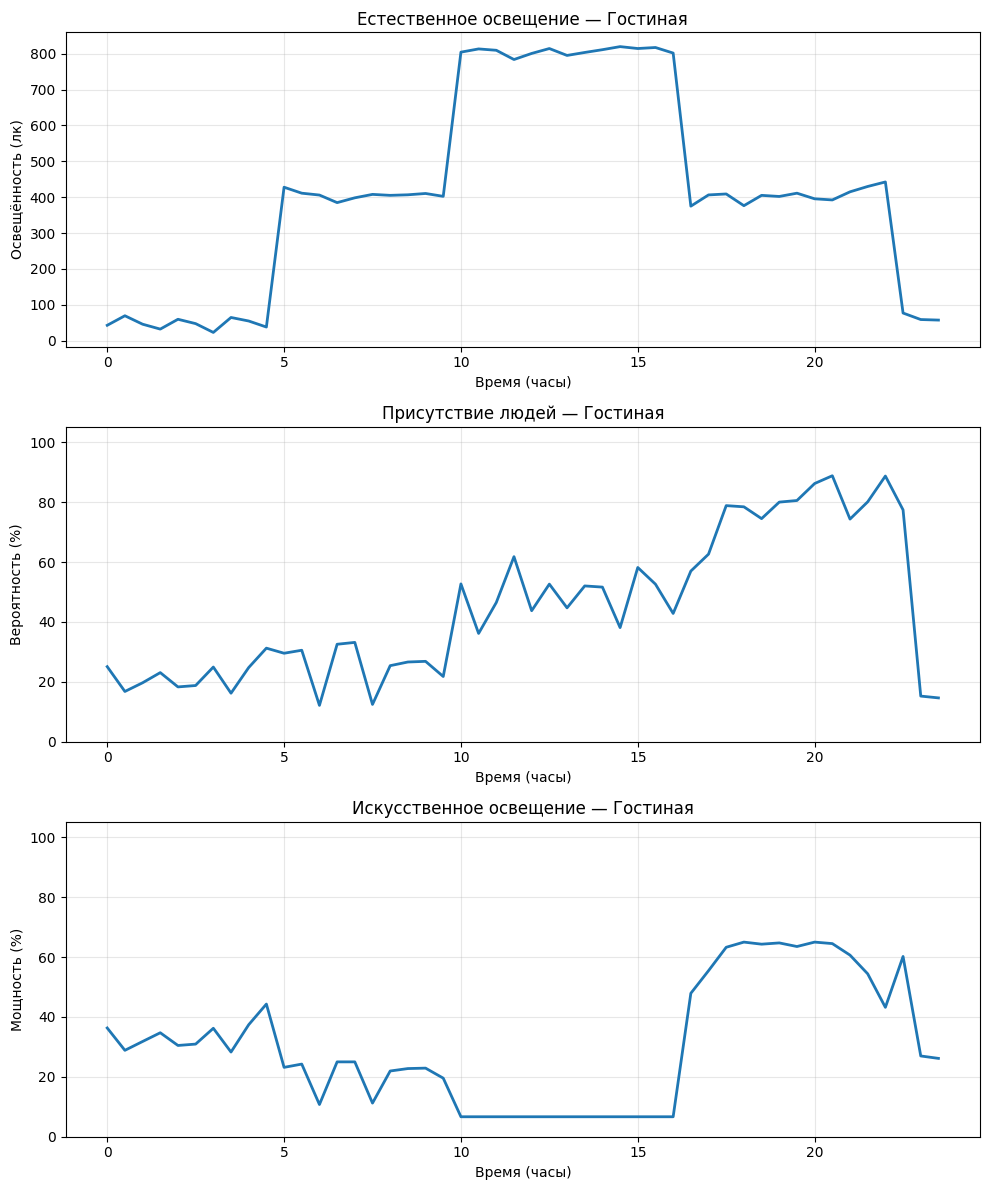

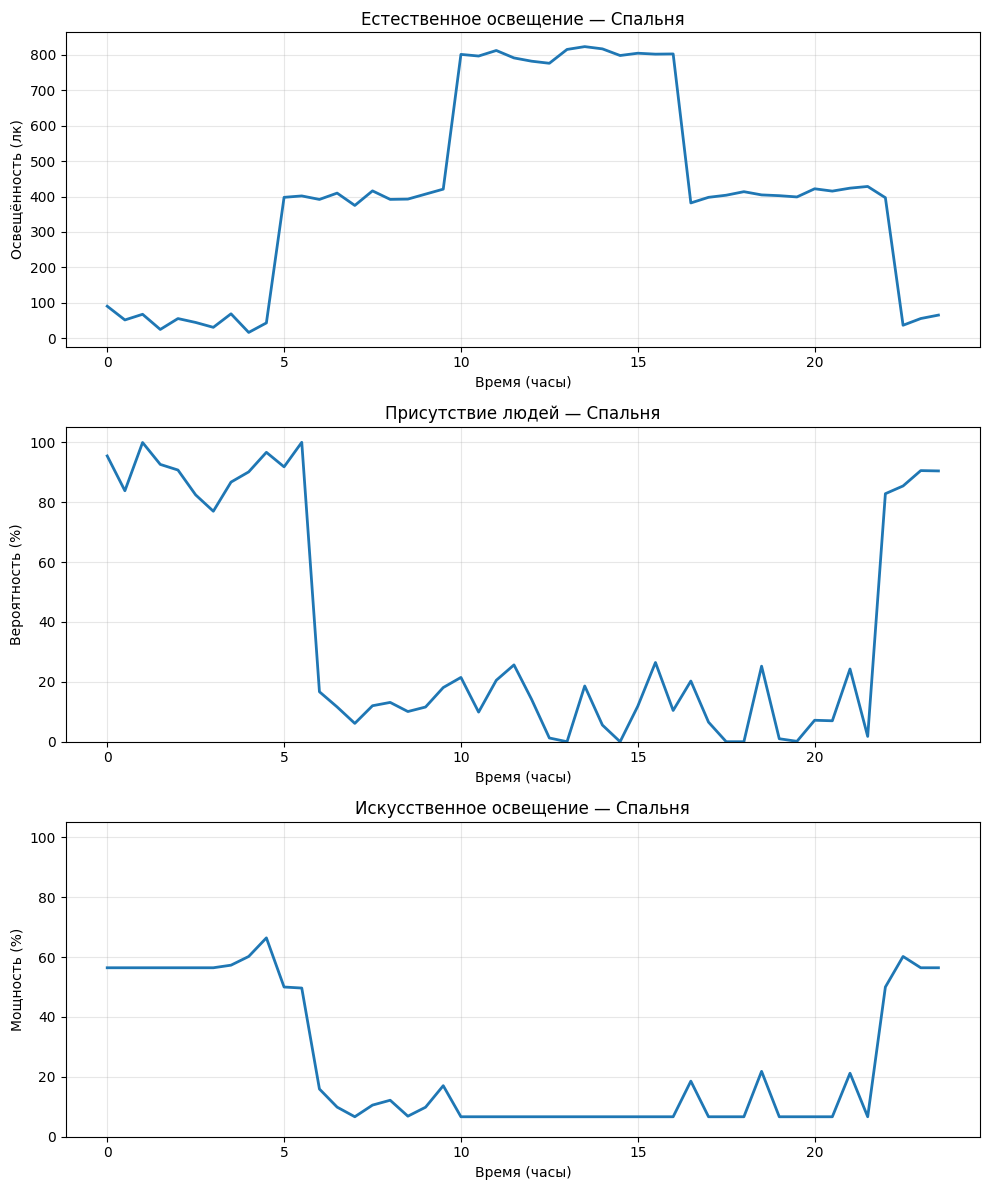

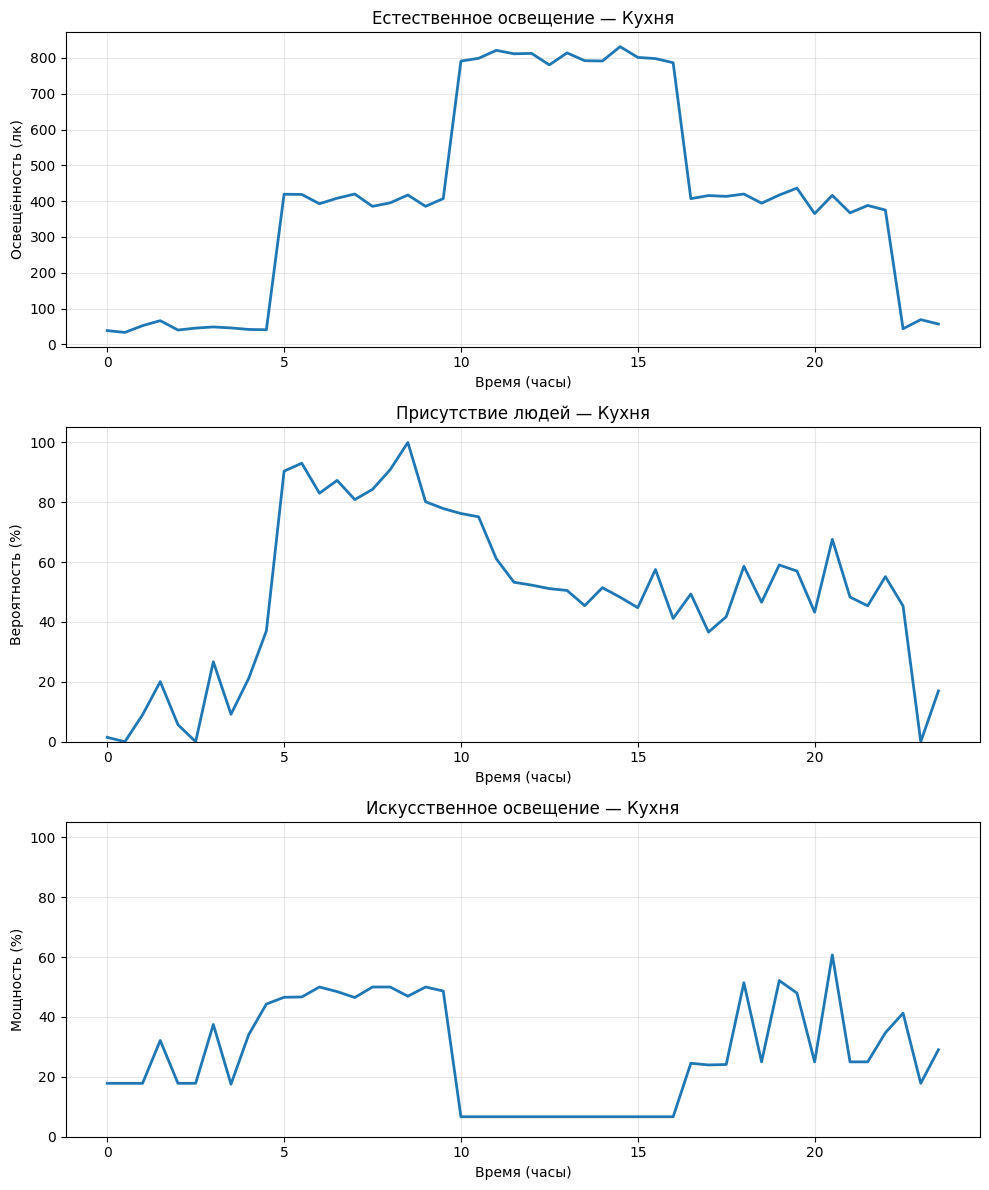


=== РЕЗУЛЬТАТЫ ===
Общее среднее энергопотребление: 27.7%
Гостиная: средняя мощность 30.4%
Спальня: средняя мощность 24.8%
Кухня: средняя мощность 27.8%

=== ТЕСТИРОВАНИЕ ===

Ночь, нет людей:
  Время: 2:00, Свет: 10лк, Люди: 5%
  Решение: мощность 17.8%

Утро, семья в гостиной:
  Время: 8:00, Свет: 100лк, Люди: 80%
  Решение: мощность 80.0%

День, солнечно:
  Время: 14:00, Свет: 800лк, Люди: 40%
  Решение: мощность 6.7%

Вечер, семья:
  Время: 20:00, Свет: 50лк, Люди: 90%
  Решение: мощность 80.0%

Вечер, мало людей:
  Время: 21:00, Свет: 100лк, Люди: 20%
  Решение: мощность 35.9%



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import json
import os

class FuzzyLightController:
    """Упрощенный контроллер нечеткой логики для освещения"""
    
    def __init__(self, config_file='fuzzy_config.json'):
        self.config = self._load_config(config_file)
        
        # Входные переменные
        self.time = ctrl.Antecedent(np.arange(0, 24, 1), 'time')
        self.light = ctrl.Antecedent(np.arange(0, 1001, 1), 'light')
        self.people = ctrl.Antecedent(np.arange(0, 101, 1), 'people')
        
        # Выходная переменная (ограничена 0-100)
        self.power = ctrl.Consequent(np.arange(0, 101, 1), 'power')
        
        # Функции принадлежности
        self._setup_fuzzy_sets()
        self._setup_rules()
    
    def _load_config(self, config_file):
        """Загрузка конфигурации из JSON"""
        if os.path.exists(config_file):
            with open(config_file, 'r') as f:
                return json.load(f)
        else:
            # Конфигурация по умолчанию
            default_config = {
                "fuzzy_sets": {
                    "time": {
                         "night1": [0, 0, 5, 5],
                        "morning": [5, 5, 10, 10],
                        "day": [10, 10, 16, 16],
                        "evening": [16, 16, 22, 22],
                        "night2": [22, 22, 24, 24]
                    },
                    "light": {
                        "dark": [0, 0, 100, 200],
                        "medium": [100, 200, 400, 600],
                        "bright": [400, 600, 1000, 1000]
                    },
                    "people": {
                        "none": [0, 0, 10, 30],
                        "few": [10, 30, 50, 70],
                        "many": [50, 70, 100, 100]
                    },
                    "power": {
                        "off": [0, 0, 20],
                        "low": [10, 25, 40],
                        "medium": [30, 50, 70],
                        "high": [60, 80, 100]
                    }
                },
                "rules": [
                    {"condition": "people.none", "action": "power.off"},
                    {"condition": "light.bright", "action": "power.off"},
                    {"condition": "people.few & light.dark", "action": "power.medium"},
                    {"condition": "people.few & light.medium", "action": "power.low"},
                    {"condition": "people.many & light.dark", "action": "power.high"},
                    {"condition": "people.many & light.medium", "action": "power.medium"},
                    {"condition": "time.night & people.few", "action": "power.low"},
                    {"condition": "time.evening & people.many", "action": "power.high"}
                ]
            }
            # Сохраняем конфиг по умолчанию
            with open(config_file, 'w') as f:
                json.dump(default_config, f, indent=2, ensure_ascii=False)
            return default_config
    
    def _setup_fuzzy_sets(self):
        """Настройка нечетких множеств из конфига"""
        fs = self.config["fuzzy_sets"]
        
        # Время суток
        for term, params in fs["time"].items():
            self.time[term] = fuzz.trapmf(self.time.universe, params)
        
        # Освещенность
        for term, params in fs["light"].items():
            self.light[term] = fuzz.trapmf(self.light.universe, params)
        
        # Люди
        for term, params in fs["people"].items():
            self.people[term] = fuzz.trapmf(self.people.universe, params)
        
        # Мощность освещения
        for term, params in fs["power"].items():
            self.power[term] = fuzz.trimf(self.power.universe, params)
    
    def _setup_rules(self):
        """Настройка правил из конфига"""
        rules = []
        
        for rule_config in self.config["rules"]:
            condition = rule_config["condition"]
            action = rule_config["action"]
            
            # Парсим условие
            if '&' in condition:
                parts = condition.split('&')
                antecedent = self._parse_antecedent(parts[0].strip()) & self._parse_antecedent(parts[1].strip())
            else:
                antecedent = self._parse_antecedent(condition)
            
            # Парсим действие
            consequent = self._parse_consequent(action)
            
            rules.append(ctrl.Rule(antecedent, consequent))
        
        self.system = ctrl.ControlSystem(rules)
        self.simulator = ctrl.ControlSystemSimulation(self.system)
    
    def _parse_antecedent(self, condition):
        """Парсинг условия правила"""
        var_name, term = condition.split('.')
        
        if var_name == 'time':
            return self.time[term]
        elif var_name == 'light':
            return self.light[term]
        elif var_name == 'people':
            return self.people[term]
        else:
            raise ValueError(f"Неизвестная переменная: {var_name}")
    
    def _parse_consequent(self, action):
        """Парсинг действия правила"""
        var_name, term = action.split('.')
        
        if var_name == 'power':
            return self.power[term]
        else:
            raise ValueError(f"Неизвестная переменная: {var_name}")
    
    def compute(self, time_val, light_val, people_val):
        """Вычисление мощности освещения с ограничением 0-100%"""
        try:
            self.simulator.input['time'] = time_val
            self.simulator.input['light'] = light_val
            self.simulator.input['people'] = people_val
            self.simulator.compute()
            power = self.simulator.output['power']
            # Ограничиваем значение 0-100%
            return max(0, min(100, power))
        except:
            # Простая логика при ошибке
            if people_val < 20 or light_val > 700:
                return 0
            elif light_val > 300:
                return 30
            else:
                return min(100, 70 if people_val > 50 else 40)

class Room:
    """Упрощенная модель комнаты"""
    
    def __init__(self, name, pattern_type, room_config):
        self.name = name
        self.pattern_type = pattern_type
        self.config = room_config
        self.people = 0
        self.natural_light = 0
        
    def _get_people_pattern(self, hour):
        """Паттерны присутствия людей из конфига"""
        hour_int = int(hour)
        patterns = self.config["people_patterns"][self.pattern_type]
        
        # Сначала проверяем специальные диапазоны (например, "21-6" для ночи)
        for time_range, value in patterns.items():
            if time_range == "default":
                continue  # Пропускаем default, он будет использован в конце
                
            if '-' in time_range:
                try:
                    start, end = map(int, time_range.split('-'))
                    # Обработка диапазона через полночь (например, 21-6)
                    if start > end:
                        if hour_int >= start or hour_int <= end:
                            return value
                    else:
                        if start <= hour_int <= end:
                            return value
                except ValueError:
                    continue  # Пропускаем некорректные форматы
        
        # Возвращаем значение по умолчанию
        return patterns.get("default", 20)
    
    def update(self, hour):
        """Обновление состояния комнаты"""
        # Присутствие людей по паттерну
        base_people = self._get_people_pattern(hour)
        
        # Добавляем случайность
        noise = np.random.normal(0, self.config.get("people_noise", 8))
        self.people = base_people + noise
        self.people = max(0, min(100, self.people))
        
        # Естественное освещение
        if 10 <= hour <= 16: # пик днём
            self.natural_light = 800
        elif 5 <= hour < 10: # утро — среднее
            self.natural_light = 400
        elif 16 < hour <= 22: # вечер — среднее
            self.natural_light = 400
        else: # ночь — минимальное
            self.natural_light = 50
            
        # Добавляем шум и ограничиваем
        light_noise = np.random.normal(0, self.config.get("light_noise", 15))
        self.natural_light += light_noise
        self.natural_light = max(5, min(1000, self.natural_light))
        
        return self.people, self.natural_light

def create_config_files():
    """Создание конфигурационных файлов"""
    
    # Конфиг для нечеткой логики
    fuzzy_config = {
        "fuzzy_sets": {
            "time": {
                "night1": [0, 0, 3, 5],
                "morning": [5, 7, 8, 10],
                "day": [10, 12, 14, 16],
                "evening": [16, 18, 20, 22],
                "night2": [22, 23, 24, 24]
            },
            "light": {
                "dark": [0, 0, 100, 200],
                "medium": [100, 200, 400, 600],
                "bright": [400, 600, 1000, 1000]
            },
            "people": {
                "none": [0, 0, 10, 30],
                "few": [10, 30, 50, 70],
                "many": [50, 70, 100, 100]
            },
            "power": {
                "off": [0, 0, 20],
                "low": [10, 25, 40],
                "medium": [30, 50, 70],
                "high": [60, 80, 100]
            }
        },
        "rules": [
            {"condition": "people.none", "action": "power.off"},
            {"condition": "light.bright", "action": "power.off"},
            {"condition": "time.night1", "action": "power.low"},
            {"condition": "time.night2", "action": "power.low"},
            {"condition": "people.few & light.dark", "action": "power.medium"},
            {"condition": "people.few & light.medium", "action": "power.low"},
            {"condition": "people.many & light.dark", "action": "power.high"},
            {"condition": "people.many & light.medium", "action": "power.medium"},
            {"condition": "time.evening & people.many", "action": "power.high"}
        ]
    }
    
    # Конфиг для комнат
    room_config = {
        "people_noise": 8,
        "light_noise": 15,
        "people_patterns": {
            "living_room": {
                "10-16": 50,
                "16-22": 80,
                "default": 20
            },
            "bedroom": {
                "0-5": 90,
                "22-24": 90,
                "default": 10
            },
            "kitchen": {
                "5-10": 85,
                "10-16": 50,
                "16-22": 50,
                "default": 15
            }
        }
    }
    
    # Конфиг для симуляции
    simulation_config = {
        "rooms": [
            {"name": "Гостиная", "type": "living_room"},
            {"name": "Спальня", "type": "bedroom"},
            {"name": "Кухня", "type": "kitchen"}
        ],
        "time_step": 0.5,
        "output_interval": 2,
        "test_scenarios": [
            {"name": "Ночь, нет людей", "time": 2, "light": 10, "people": 5},
            {"name": "Утро, семья в гостиной", "time": 8, "light": 100, "people": 80},
            {"name": "День, солнечно", "time": 14, "light": 800, "people": 40},
            {"name": "Вечер, семья", "time": 20, "light": 50, "people": 90},
            {"name": "Вечер, мало людей", "time": 21, "light": 100, "people": 20}
        ]
    }
    
    # Сохраняем конфиги
    with open('fuzzy_config.json', 'w') as f:
        json.dump(fuzzy_config, f, indent=2, ensure_ascii=False)
    
    with open('room_config.json', 'w') as f:
        json.dump(room_config, f, indent=2, ensure_ascii=False)
    
    with open('simulation_config.json', 'w') as f:
        json.dump(simulation_config, f, indent=2, ensure_ascii=False)
    
    print("Конфигурационные файлы созданы:")
    print("- fuzzy_config.json")
    print("- room_config.json") 
    print("- simulation_config.json")

def plot_fuzzy_sets(controller):
    """Визуализация нечетких множеств"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Время
    for label in controller.time.terms:
        ax1.plot(controller.time.universe, fuzz.interp_membership(
            controller.time.universe, controller.time[label].mf, controller.time.universe), 
            label=label, linewidth=2)
    ax1.set_title('Время суток')
    ax1.set_xlabel('Часы')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Освещенность
    for label in controller.light.terms:
        ax2.plot(controller.light.universe, fuzz.interp_membership(
            controller.light.universe, controller.light[label].mf, controller.light.universe), 
            label=label, linewidth=2)
    ax2.set_title('Естественное освещение')
    ax2.set_xlabel('Люксы')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Люди
    for label in controller.people.terms:
        ax3.plot(controller.people.universe, fuzz.interp_membership(
            controller.people.universe, controller.people[label].mf, controller.people.universe), 
            label=label, linewidth=2)
    ax3.set_title('Присутствие людей')
    ax3.set_xlabel('Вероятность (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Мощность
    for label in controller.power.terms:
        ax4.plot(controller.power.universe, fuzz.interp_membership(
            controller.power.universe, controller.power[label].mf, controller.power.universe), 
            label=label, linewidth=2)
    ax4.set_title('Мощность освещения')
    ax4.set_xlabel('Мощность (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def simulate_day():
    """Симуляция одного дня с конфигами из JSON"""
    
    # Загружаем конфиги
    if not os.path.exists('room_config.json') or not os.path.exists('simulation_config.json'):
        create_config_files()
    
    with open('room_config.json', 'r') as f:
        room_config = json.load(f)
    
    with open('simulation_config.json', 'r') as f:
        sim_config = json.load(f)
    
    # Создаем контроллер и комнаты
    controller = FuzzyLightController('fuzzy_config.json')
    rooms = {}
    
    for room_info in sim_config["rooms"]:
        name = room_info["name"]
        room_type = room_info["type"]
        rooms[name] = Room(name, room_type, room_config)
    
    print("=== СИМУЛЯЦИЯ УМНОГО ОСВЕЩЕНИЯ ===\n")
    print("Конфигурация загружена из JSON файлов\n")
    
    # Данные для графиков
    times = []
    results = {name: {'light': [], 'people': [], 'power': []} for name in rooms}
    
    # Симуляция
    time_step = sim_config.get("time_step", 0.5)
    output_interval = sim_config.get("output_interval", 2)
    
    for hour in np.arange(0, 24, time_step):
        times.append(hour)
        
        for name, room in rooms.items():
            people, light = room.update(hour)
            power = controller.compute(hour, light, people)
            
            results[name]['light'].append(light)
            results[name]['people'].append(people)
            results[name]['power'].append(power)
            
        # Вывод состояния
        if hour % output_interval == 0:
            print(f"--- {hour:.1f} часов ---")
            for name, room in rooms.items():
                idx = len(times) - 1
                print(f"{name}: вероятность присутствия людей = {results[name]['people'][idx]:.0f}%, "
                      f"естественный свет = {results[name]['light'][idx]:.0f}лк, "
                      f"мощность искуственного освещения = {results[name]['power'][idx]:.0f}%")
    
    # Графики результатов
    
    for name in rooms:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

        # Естественное освещение
        ax1.plot(times, results[name]['light'], linewidth=2)
        ax1.set_title(f'Естественное освещение — {name}')
        ax1.set_xlabel('Время (часы)')
        ax1.set_ylabel('Освещённость (лк)')
        ax1.grid(True, alpha=0.3)

        # Люди
        ax2.plot(times, results[name]['people'], linewidth=2)
        ax2.set_title(f'Присутствие людей — {name}')
        ax2.set_xlabel('Время (часы)')
        ax2.set_ylabel('Вероятность (%)')
        ax2.set_ylim(0, 105)
        ax2.grid(True, alpha=0.3)

        # Искусственное освещение (мощность)
        ax3.plot(times, results[name]['power'], linewidth=2)
        ax3.set_title(f'Искусственное освещение — {name}')
        ax3.set_xlabel('Время (часы)')
        ax3.set_ylabel('Мощность (%)')
        ax3.set_ylim(0, 105)
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # Статистика
    avg_powers = [sum(results[name]['power'])/len(times) for name in rooms]
    total_avg_power = sum(avg_powers) / len(avg_powers)
    print(f"\n=== РЕЗУЛЬТАТЫ ===")
    print(f"Общее среднее энергопотребление: {total_avg_power:.1f}%")
    for name, avg_power in zip(rooms.keys(), avg_powers):
        print(f"{name}: средняя мощность {avg_power:.1f}%")

def test_scenarios():
    """Тестирование сценариев из JSON"""
    controller = FuzzyLightController('fuzzy_config.json')
    
    # Загружаем сценарии
    with open('simulation_config.json', 'r', encoding='utf-8') as f:
        sim_config = json.load(f)
    
    tests = sim_config.get("test_scenarios", [])
    
    print("\n=== ТЕСТИРОВАНИЕ ===\n")
    for test in tests:
        power = controller.compute(test["time"], test["light"], test["people"])
        print(f"{test['name']}:")
        print(f"  Время: {test['time']}:00, Свет: {test['light']}лк, Люди: {test['people']}%")
        print(f"  Решение: мощность {power:.1f}%\n")

def main():
    # Создаем конфигурационные файлы если их нет
    if not all(os.path.exists(f) for f in ['fuzzy_config.json', 'room_config.json', 'simulation_config.json']):
        create_config_files()
    
    # Запуск симуляции
    simulate_day()
    
    # Тестирование
    test_scenarios()

main()